In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import importlib
import sys
sys.path.insert(0, '../utils')
import data_utils
import visualization
import evaluation

# importlib.reload(visualization)

In [4]:
np.random.seed(42)

In [5]:
df_train = data_utils.load_data_set('../data/train/train.csv')
df_train_x = df_train[['head.word', 'tail.word', 'sentence']]
df_train_y = df_train['relation']

In [6]:
df_test = data_utils.load_data_set('../data/test/test.csv')
df_test_x = df_test[['head.word', 'tail.word', 'sentence']]
df_test_y = df_test['relation']

In [7]:
df_full = df_train.append(df_test)

In [8]:
df_full['head.word']

0                      Syracuse
1                      Syracuse
2                      Syracuse
3                        Turkey
4                        Turkey
5                        Queens
6                        Queens
7                        Queens
8                        Queens
9                        Queens
10                       Queens
11                       Queens
12                       Queens
13                       Queens
14                       Queens
15                      Hokusai
16        Chandrika Kumaratunga
17        Chandrika Kumaratunga
18        Chandrika Kumaratunga
19                   California
20              Pietro Annigoni
21             Barbara Stanwyck
22                  Jorge Amado
23                Lauren Conrad
24                Lauren Conrad
25               Roland Barthes
26               North Carolina
27                        Amway
28           Simone de Beauvoir
29           Simone de Beauvoir
                  ...          
172418  

In [8]:
with open('../data/classes.json') as f:
    classes_json = json.load(f)
classes = np.asarray(list(classes_json.keys()))

In [9]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(df_train_y), df_train_y)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1932.414814814815,
 1: 19.302700702922678,
 2: 53.02357723577236,
 3: 26.839094650205762,
 4: 8695.866666666667,
 5: 2.370737913486005,
 6: 966.2074074074075,
 7: 966.2074074074075,
 8: 2.387007045475341,
 9: 4347.933333333333,
 10: 2.387007045475341,
 11: 1.9578670869451011,
 12: 0.2606635591992526,
 13: 1.875119496855346,
 14: 445.94188034188033,
 15: 158.10666666666665,
 16: 21.794152046783626,
 17: 724.6555555555556,
 18: 7.180732177263969,
 19: 202.22945736434107,
 20: 27.960986066452303,
 21: 117.51171171171171,
 22: 1.7872503682389613,
 23: 1.9530301328841475,
 24: 4.291076568796776,
 25: 86.09768976897689,
 26: 724.6555555555556,
 27: 59.15555555555556,
 28: 4347.933333333333,
 29: 0.04510596727830729}

In [10]:
MAX_WORDS = 150000 / 3
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

MAX_ENTITY_WORDS = 40000 / 2
MAX_ENTITY_LENGTH = 4
ENTITY_EMBEDDING_DIM = 100

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_full['sentence'])
word_index = tokenizer.word_index

In [13]:
entity_tokenizer = Tokenizer(num_words=MAX_ENTITY_WORDS)
entity_tokenizer.fit_on_texts(df_full['head.word'].append(df_full['tail.word']))
entity_word_index = entity_tokenizer.word_index

In [14]:
len(entity_word_index)

40124

In [15]:
# load GloVe 100 dim word embeddings
embeddings_index = {}
f = open('../data/external/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
# use word_index and embeddings_index to construct embedding_matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_matrix.shape

(147420, 100)

In [18]:
# use entity_word_index and embeddings_index to construct entity_embedding_matrix
entity_embedding_matrix = np.zeros((len(entity_word_index) + 1, ENTITY_EMBEDDING_DIM))
for word, i in entity_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        entity_embedding_matrix[i] = embedding_vector

In [19]:
entity_embedding_matrix.shape

(40125, 100)

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, concatenate, multiply
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# head
head_input = Input(shape=(MAX_ENTITY_LENGTH,))
head_embedding = Embedding(len(entity_word_index) + 1,
                           ENTITY_EMBEDDING_DIM,
                           weights=[entity_embedding_matrix],
                           input_length=MAX_ENTITY_LENGTH,
                           trainable=False)(head_input)
head_conv = Conv1D(32, 3)(head_embedding)
head_pooling = MaxPooling1D(2)(head_conv)
head_flatten = Flatten()(head_pooling)

# tail
tail_input = Input(shape=(MAX_ENTITY_LENGTH,))
tail_embedding = Embedding(len(entity_word_index) + 1,
                           ENTITY_EMBEDDING_DIM,
                           weights=[entity_embedding_matrix],
                           input_length=MAX_ENTITY_LENGTH,
                           trainable=False)(tail_input)
tail_conv = Conv1D(32, 3)(tail_embedding)
tail_pooling = MaxPooling1D(2)(tail_conv)
tail_flatten = Flatten()(tail_pooling)


#sentence
sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentence_embedding = Embedding(len(word_index) + 1,
                               EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)(sentence_input)
sentence_bilstm = Bidirectional(LSTM(50))(sentence_embedding) # otuput shape is LSTM units doubled
sentence_attention_probs = Dense(100, activation='softmax', name='attention_vec')(sentence_bilstm)
sentence_attention_mul = multiply([sentence_bilstm, sentence_attention_probs])

# combined model
merge = concatenate([head_flatten, tail_flatten, sentence_attention_mul])
dropout = Dropout(0.2)(merge)
hidden = Dense(64, activation='relu')(dropout)
output = Dense(len(classes), activation='softmax')(hidden)

model = Model(inputs=[head_input, tail_input, sentence_input],
              outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 4, 100)       4012500     input_31[0][0]                   
__________________________________________________________________________________________________
embedding_

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='bilstm.png')

In [34]:
train_sequences = tokenizer.texts_to_sequences(df_train_x['sentence'])

In [35]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [36]:
padded_train_head = pad_sequences(entity_tokenizer.texts_to_sequences(df_train_x['head.word']), maxlen=MAX_ENTITY_LENGTH)
padded_train_tail = pad_sequences(entity_tokenizer.texts_to_sequences(df_train_x['tail.word']), maxlen=MAX_ENTITY_LENGTH)

In [37]:
# from tensorflow.keras.utils import to_categorical
# labels = to_categorical(classes)

from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
label_encoder.fit(classes.reshape(-1, 1))

labels = label_encoder.transform(df_train_y.values.reshape(-1, 1)).todense()

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [38]:
print('Shape of data tensor:', padded_train_sequences.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (521752, 100)
Shape of label tensor: (521752, 30)


In [39]:
history = model.fit(
    [padded_train_head, padded_train_tail, padded_train_sequences],
    np.asarray(labels),
    epochs=5,
    batch_size=200,
#     class_weight=class_weights_dict,
    validation_split=0.2
)

Train on 417401 samples, validate on 104351 samples
Epoch 1/5
417401/417401 [==============================] - 339s 812us/step - loss: 0.4768 - acc: 0.8340 - val_loss: 0.2202 - val_acc: 0.9108
Epoch 2/5
417401/417401 [==============================] - 344s 825us/step - loss: 0.3209 - acc: 0.8758 - val_loss: 0.2074 - val_acc: 0.9091
Epoch 3/5
417401/417401 [==============================] - 343s 821us/step - loss: 0.2899 - acc: 0.8853 - val_loss: 0.1966 - val_acc: 0.9152
Epoch 4/5
417401/417401 [==============================] - 343s 822us/step - loss: 0.2719 - acc: 0.8917 - val_loss: 0.1970 - val_acc: 0.9165
Epoch 5/5
417401/417401 [==============================] - 344s 823us/step - loss: 0.2612 - acc: 0.8949 - val_loss: 0.2160 - val_acc: 0.9069


In [40]:
model.save('../trained_models/bi_lstm_attention_5_no_class_weights.h5')

In [41]:
test_sequences = tokenizer.texts_to_sequences(df_test_x['sentence'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [42]:
padded_test_head = pad_sequences(entity_tokenizer.texts_to_sequences(df_test_x['head.word']), maxlen=MAX_ENTITY_LENGTH)
padded_test_tail = pad_sequences(entity_tokenizer.texts_to_sequences(df_test_x['tail.word']), maxlen=MAX_ENTITY_LENGTH)

In [43]:
test_labels = label_encoder.transform(df_test_y.values.reshape(-1, 1)).todense()

In [37]:
scores = model.evaluate([padded_test_sequences], test_labels)

 20320/172442 [==>...........................] - ETA: 1:05

KeyboardInterrupt: 

In [33]:
scores

[0.2966721483257834, 0.9060031778800988]

In [45]:
predictions = model.predict([padded_test_head, padded_test_tail, padded_test_sequences])

In [46]:
predicted_labels = label_encoder.inverse_transform(predictions).ravel()

In [47]:
from collections import Counter
Counter(predicted_labels)

gold_labels = df_test_y

Counter(gold_labels)

Counter({'/people/deceased_person/place_of_death': 127,
         '/people/person/nationality': 1999,
         'NA': 158816,
         '/location/location/contains': 6387,
         '/people/person/place_lived': 1854,
         '/sports/sports_team/location': 25,
         '/business/person/company': 838,
         '/location/country/capital': 538,
         '/location/administrative_division/country': 1021,
         '/people/person/place_of_birth': 114,
         '/location/neighborhood/neighborhood_of': 258,
         '/location/country/administrative_divisions': 125,
         '/business/company/place_founded': 124,
         '/people/ethnicity/geographic_distribution': 5,
         '/business/company/founders': 152,
         '/people/person/religion': 20,
         '/location/us_county/county_seat': 2,
         '/people/person/children': 10,
         '/people/person/ethnicity': 9,
         '/business/company/major_shareholders': 18})

Counter({'/people/person/place_of_birth': 162,
         '/people/person/nationality': 723,
         '/people/person/place_lived': 450,
         '/location/location/contains': 2793,
         '/sports/sports_team/location': 10,
         '/business/person/company': 302,
         '/location/country/capital': 553,
         '/business/company/founders': 95,
         '/film/film/featured_film_locations': 2,
         '/location/administrative_division/country': 424,
         '/location/us_county/county_seat': 23,
         '/people/deceased_person/place_of_death': 68,
         '/business/company/place_founded': 20,
         '/location/neighborhood/neighborhood_of': 68,
         '/people/person/children': 30,
         '/film/film_location/featured_in_films': 2,
         '/people/ethnicity/geographic_distribution': 136,
         '/location/country/administrative_divisions': 424,
         '/location/us_state/capital': 39,
         '/business/company_advisor/companies_advised': 8,
         '/time/e

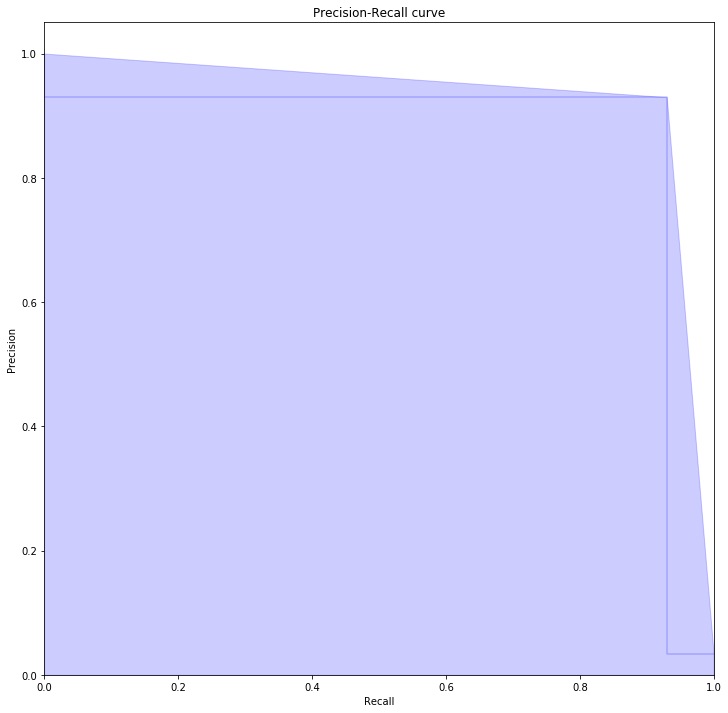

<module 'matplotlib.pyplot' from '/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [48]:
# Precision-Recall Curve
precision, recall, threshold = evaluation.compute_precision_recall_curve(
    y_true=df_test_y.values.reshape(-1, 1),
    y_pred=predicted_labels.reshape(-1, 1),
    classes=classes.reshape(-1, 1)
)

plt.rcParams["figure.figsize"] = (12, 12)
visualization.plot_precision_recall_curve(precision, recall)

In [49]:
score = evaluation.compute_score(predicted_labels, gold_labels, labels=classes)

/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(
    y_true=gold_labels,
    y_pred=predicted_labels,
    labels=classes
)
cnf_matrix

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      8],
       [     0,     23,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,     72],
       [     0,     19,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,     27],
       [     0,      0,      0,      3,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      

In [51]:
def get_results(name, config, score, cnf_matrix, history):
    return {
        'name': name,
        'config': config,
        'score': score,
        'confusion_matrix': cnf_matrix.tolist(),
        'history': history.history,
        'params': history.params
    }

import datetime
import time

def persist_results(results):    
    timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
    with open('../results/{}-{}.json'.format(timestamp, results['name']), 'w') as f:
        json.dump(results, f)


config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'MAX_ENTITY_WORDS': MAX_ENTITY_WORDS,
    'MAX_ENTITY_LENGTH': MAX_ENTITY_LENGTH,
    'ENTITY_EMBEDDING_DIM': ENTITY_EMBEDDING_DIM
}


results = get_results('bilstm_attention', config, score, cnf_matrix, history)
results
persist_results(results)

{'name': 'bilstm_attention',
 'config': {'MAX_WORDS': 50000.0,
  'MAX_SEQUENCE_LENGTH': 100,
  'EMBEDDING_DIM': 100,
  'MAX_ENTITY_WORDS': 20000.0,
  'MAX_ENTITY_LENGTH': 4,
  'ENTITY_EMBEDDING_DIM': 100},
 'score': {'accuracy': 0.9298546757750432,
  'precision': 0.960539111729804,
  'recall': 0.9298546757750432,
  'f1': 0.9417261821904576},
 'confusion_matrix': [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   8],
  [0,
   23,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   72],
  [0,
   19,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   27],
  [0,
   0,
   0,
   3,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,

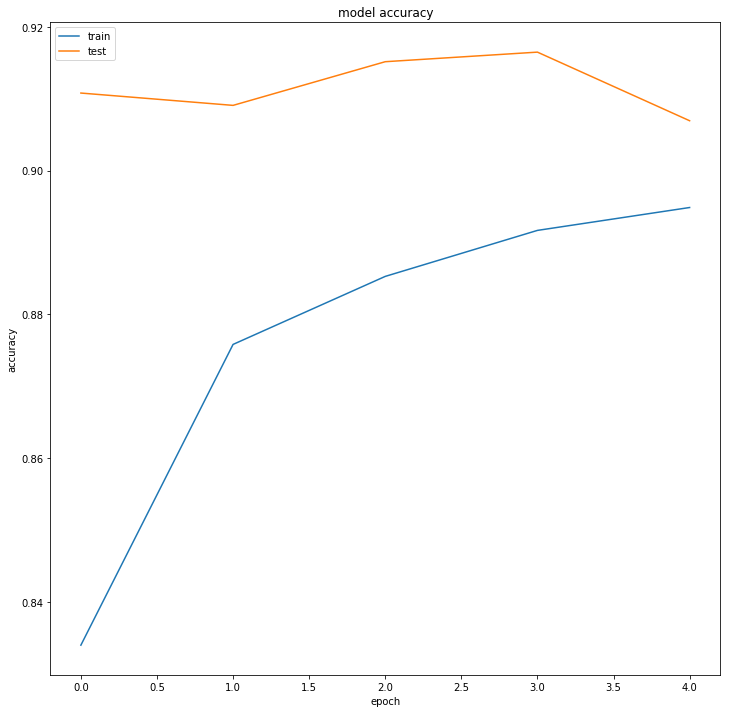

In [52]:
def visualize_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt

visualize_history(history).show()

In [53]:
history.params

{'batch_size': 200,
 'epochs': 5,
 'steps': None,
 'samples': 417401,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'validation_steps': None}

Confusion matrix, without normalization
[[     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      8]
 [     0     23      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0     72]
 [     0     19      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0     27]
 [     0      0      0      3      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0     17]
 [     0      0      0      0      0      3      0      0      0      0
       0      0     

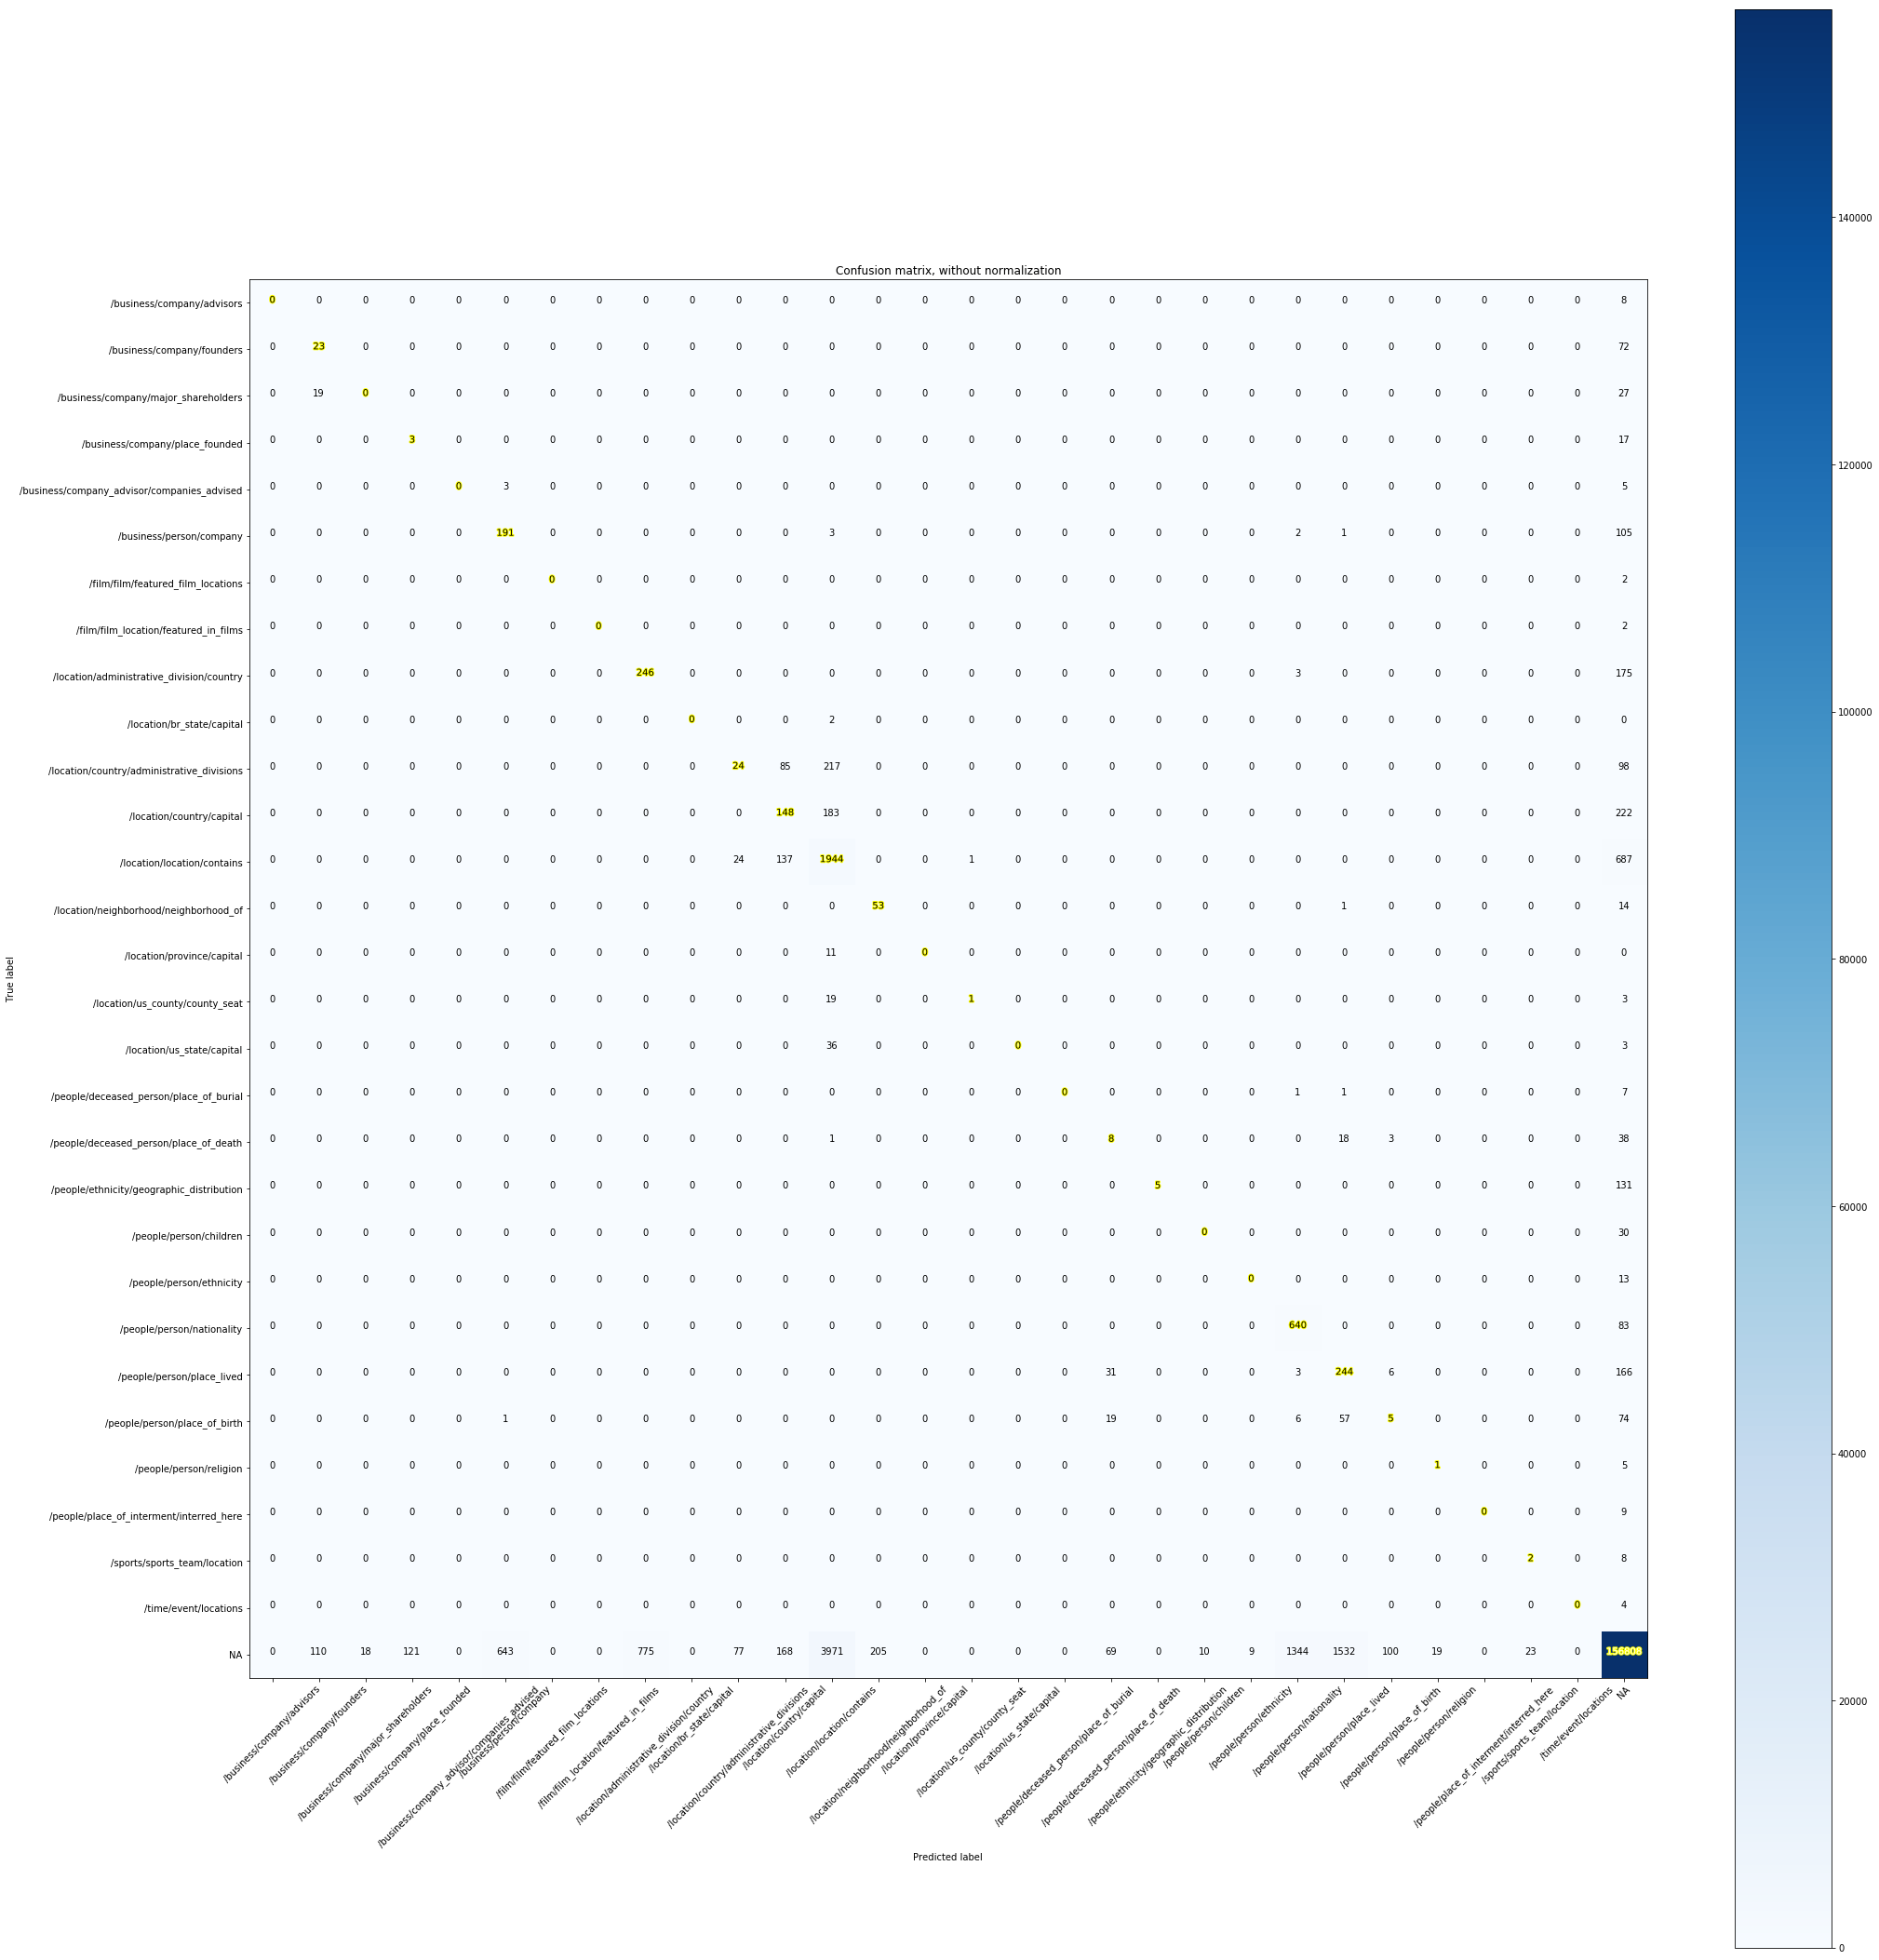

Normalized confusion matrix
[[0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 1.0e+00]
 [0.0e+00 2.4e-01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 7.6e-01]
 [0.0e+00 4.1e-01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 5.9e-01]
 [0.0e+00 0.0e+00 0.0e+00 1.5e-01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0

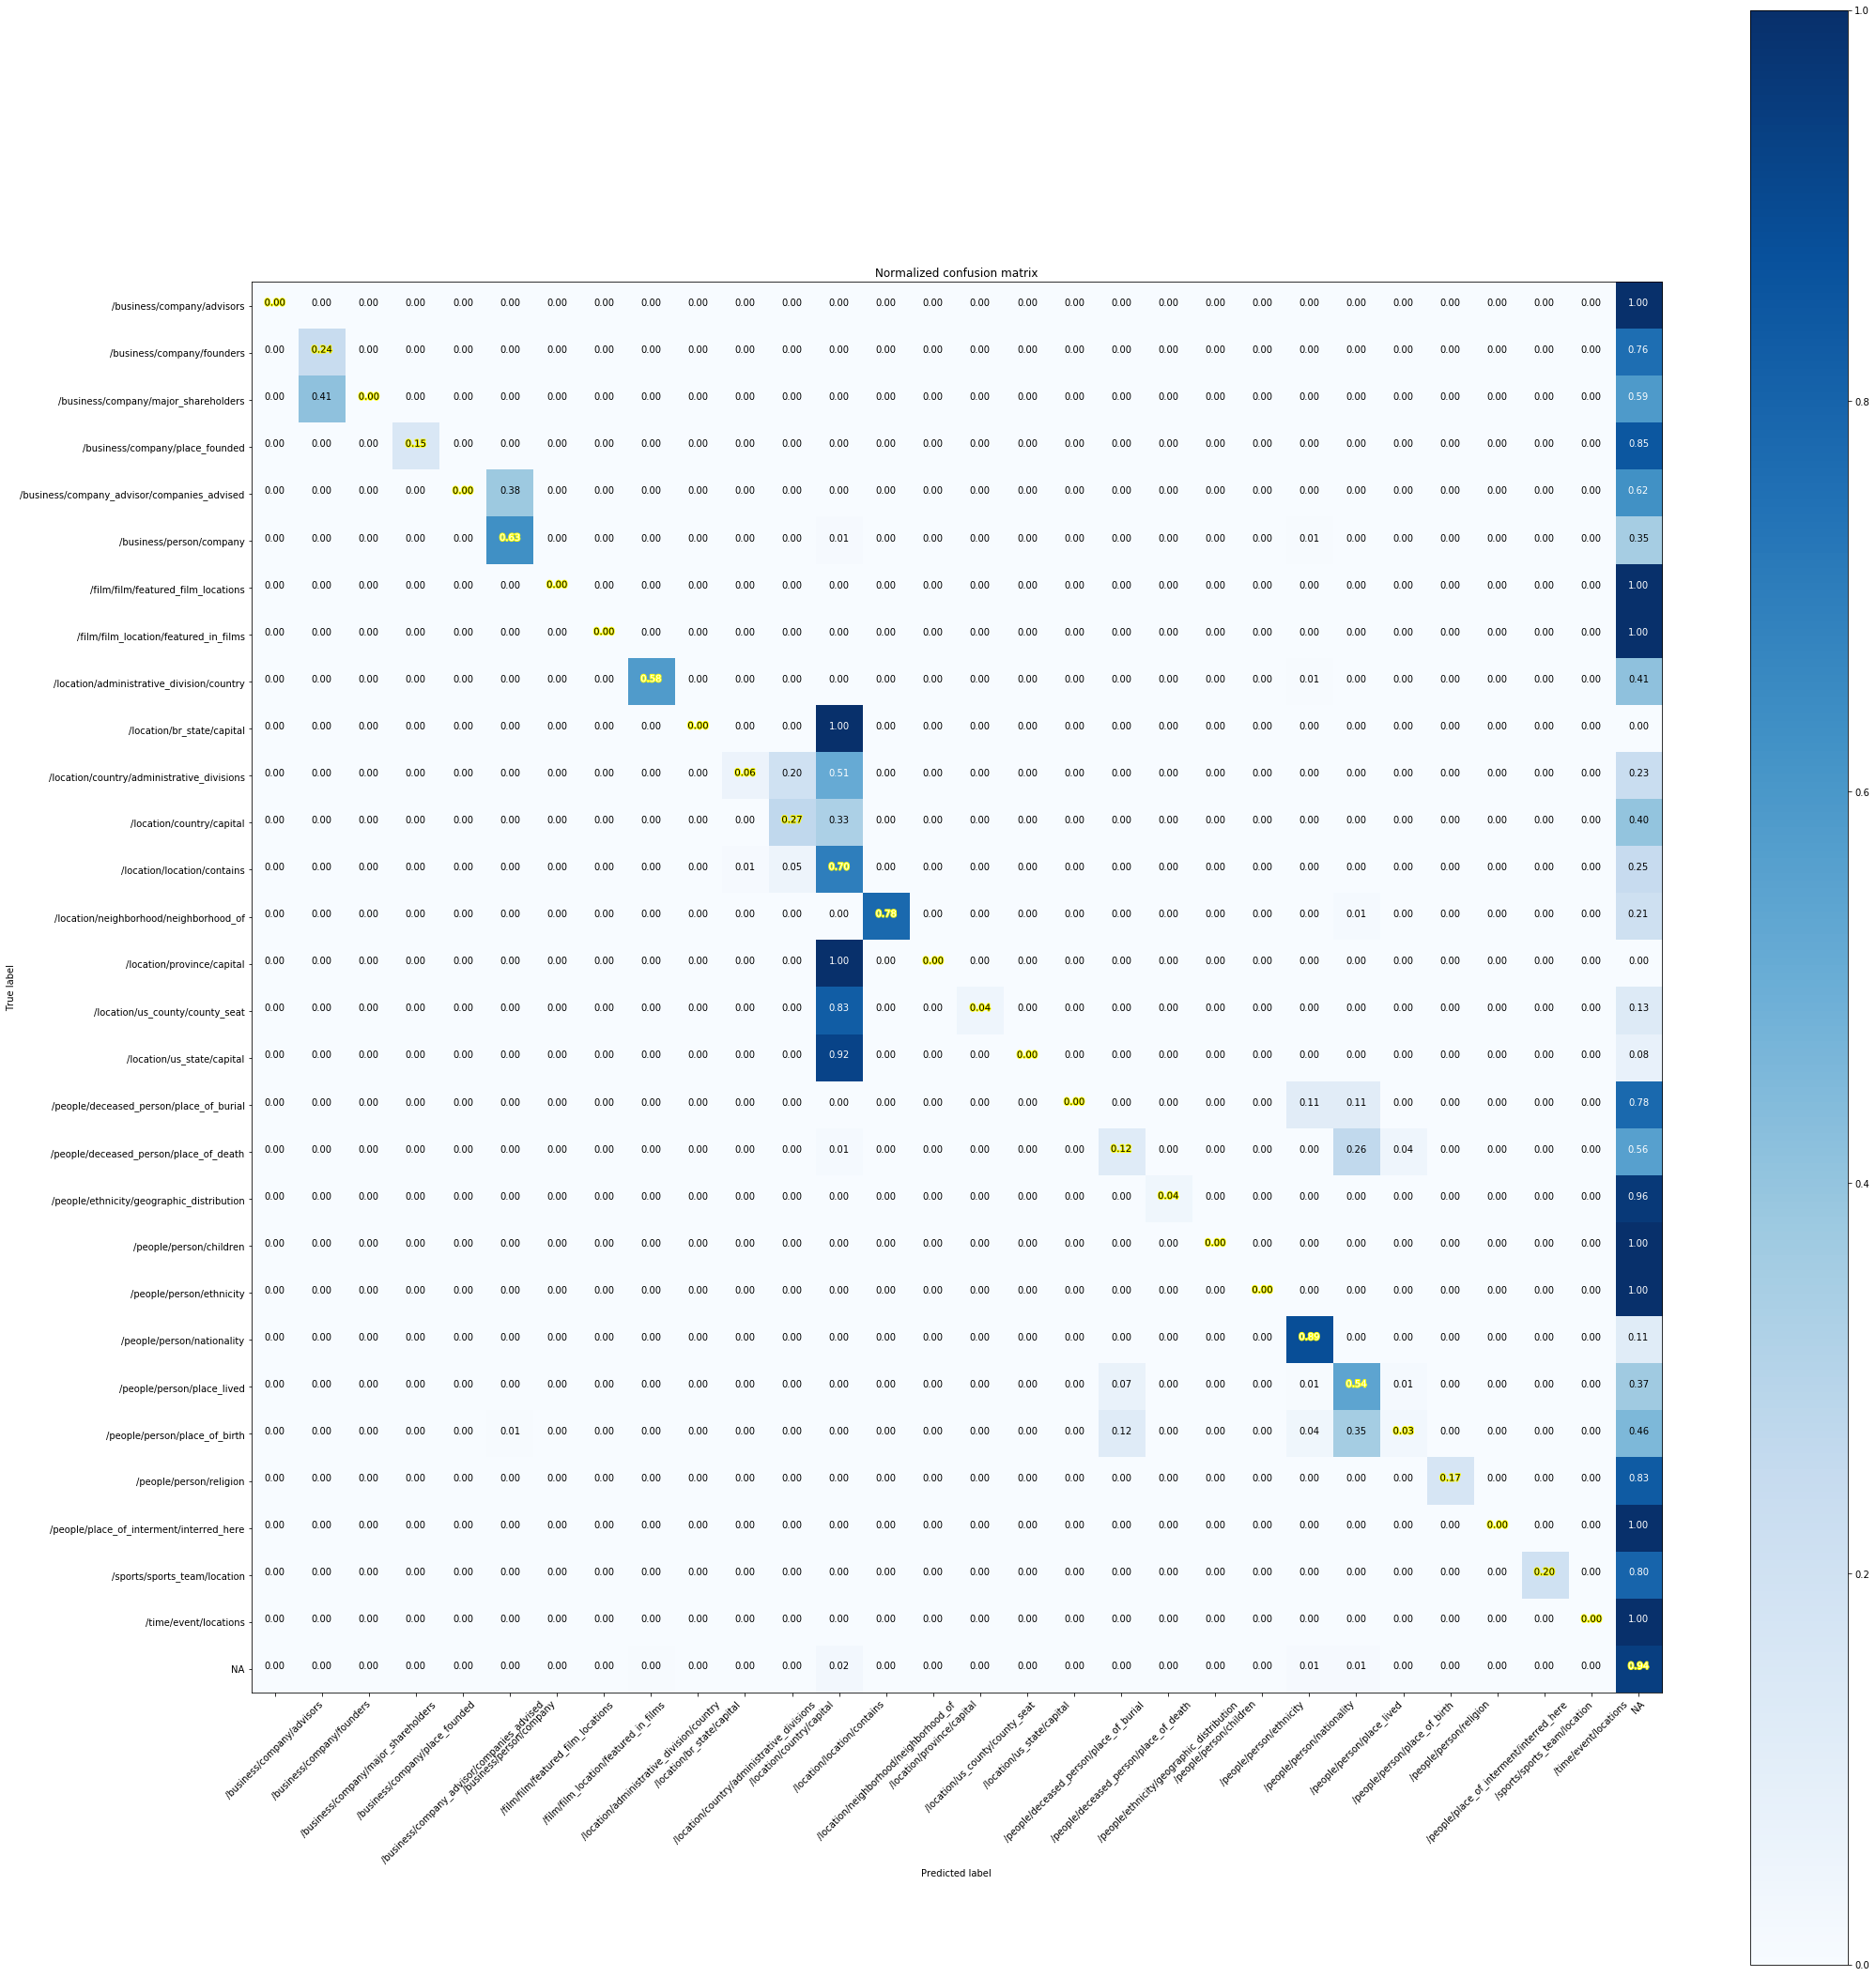

In [54]:
plt.rcParams["figure.figsize"] = (30, 30)

# Plot non-normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      title='Confusion matrix, without normalization').show()

# Plot normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix').show()

In [55]:
# used in RESIDE
def calc_prec_recall_f1(y_actual, y_pred, none_id='NA', eps=0.00000001):
    pos_pred, pos_gt, true_pos = 0.0, 0.0, 0.0

    for i in range(len(y_actual)):
        if y_actual[i] != none_id:
            pos_gt += 1.0

    for i in range(len(y_pred)):
        if y_pred[i] != none_id:
            pos_pred += 1.0                    # classified as pos example (Is-A-Relation)
            if y_pred[i] == y_actual[i]:
                true_pos += 1.0

    precision = true_pos / (pos_pred + eps)
    recall    = true_pos / (pos_gt + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    return precision, recall, f1

In [65]:
reside_precision, reside_recall, reside_f1 = calc_prec_recall_f1(gold_labels.tolist(), predicted_labels)
reside_precision, reside_recall, reside_f1

(0.25965066784070184, 0.5493788819867246, 0.35263629585020106)

In [92]:
from sklearn.metrics import average_precision_score

y_hot = np.array(label_encoder.transform(df_test_y.values.reshape(-1, 1)).todense())
logit_list = predictions

# e[:-1] removes the last class which is NA
y_true   = np.array([e[:-1] for e in y_hot]).reshape((-1))
y_scores = np.array([e[:-1] for e in logit_list]).reshape((-1))
area_pr  = average_precision_score(y_true, y_scores)
area_pr

0.2946397091584859

Precision-Recall plot saved at: ../results/plots/pr_curve_bi_lstm.png


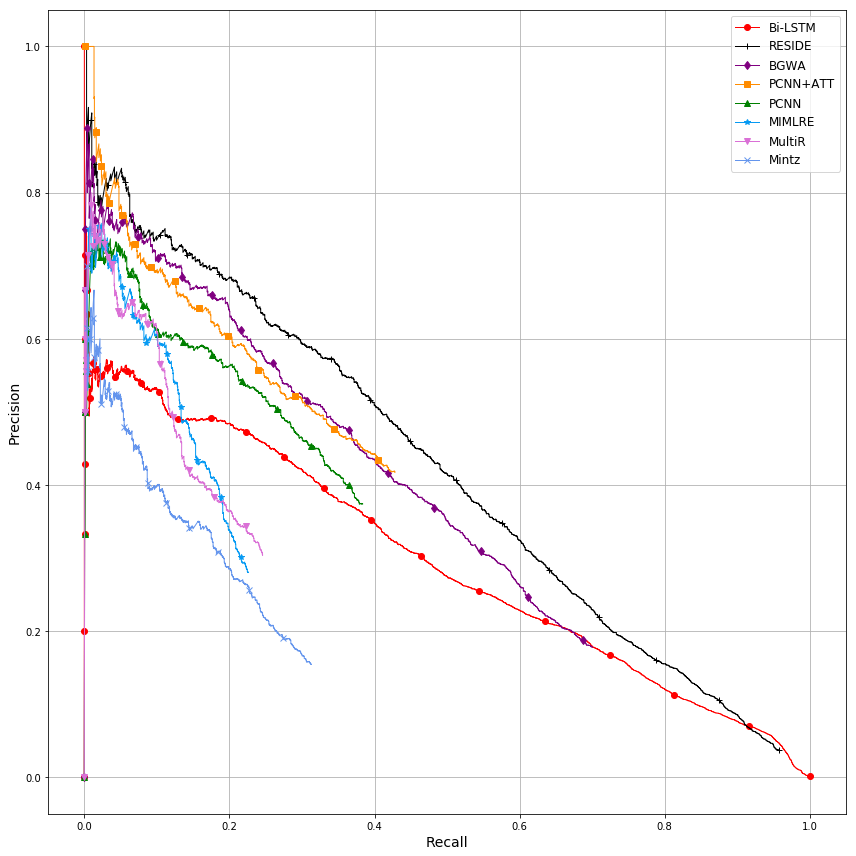

In [103]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plotPR(y_true, y_scores, name, label):
    precision,recall,threshold = precision_recall_curve(y_true,y_scores)
    area_under                 = average_precision_score(y_true, y_scores)
    baselines_path             = '../baselines_pr/'

    plt.plot(recall[:], precision[:], label=label, color ='red', lw=1, marker = 'o', markevery = 0.1, ms = 6)

    base_list = ['RESIDE', 'BGWA', 'PCNN+ATT', 'PCNN', 'MIMLRE', 'MultiR', 'Mintz']
    color     = ['black', 'purple', 'darkorange', 'green', 'xkcd:azure', 'orchid', 'cornflowerblue']
    marker    = ['+', 'd', 's', '^', '*', 'v', 'x', 'h']
#     plt.ylim([0.3, 1.0])
#     plt.xlim([0.0, 0.45])

    for i, baseline in enumerate(base_list):
        precision = np.load(baselines_path + baseline + '/precision.npy')
        recall    = np.load(baselines_path + baseline + '/recall.npy')
        plt.plot(recall, precision, color = color[i], label = baseline, lw=1, marker = marker[i], markevery = 0.1, ms = 6)

    plt.xlabel('Recall',    fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.legend(loc="upper right", prop = {'size' : 12})
    plt.grid(True)
    plt.tight_layout()

    plot_path = '../results/plots/pr_curve_{}.png'.format(name)
    plt.savefig(plot_path)
    print('Precision-Recall plot saved at: {}'.format(plot_path))
    return plt


plt.rcParams["figure.figsize"] = (12, 12)
plotPR(y_true, y_scores, name='bi_lstm', label='Bi-LSTM').show()

In [138]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13935034082298993415
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3997827162524441191
physical_device_desc: "device: XLA_CPU device"
]
